In [1]:
import os
data_dir = "gender_classification_dataset"
if not os.path.isdir(data_dir):
    from google.colab import drive
    drive.mount("/content/drive")
    !cp "/content/drive/MyDrive/Myntra/gender_classification_dataset.zip" "/content/"
    !unzip "gender_classification_dataset.zip"
    !rm "gender_classification_dataset.zip"
    !mv "data/" "gender_classification_dataset/"
    !mv "men/" "gender_classification_dataset/men/"
    !mv "women/" "gender_classification_dataset/women/"
    print("Data Loaded Sucessfully!")
else:
    print("Data already loaded!")

Data already loaded!


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import resnet, ResNet50
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import metrics, losses, optimizers, callbacks

In [3]:
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
EPOCHS = 100
LEARNING_RATE = 1e-3
TARGET_SHAPE = (224,224,3)

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,image_size=TARGET_SHAPE[:2],batch_size=BATCH_SIZE)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,image_size=TARGET_SHAPE[:2],batch_size=BATCH_SIZE)

class_names = train_dataset.class_names

Found 6660 files belonging to 2 classes.
Using 5328 files for training.
Found 6660 files belonging to 2 classes.
Using 1332 files for validation.


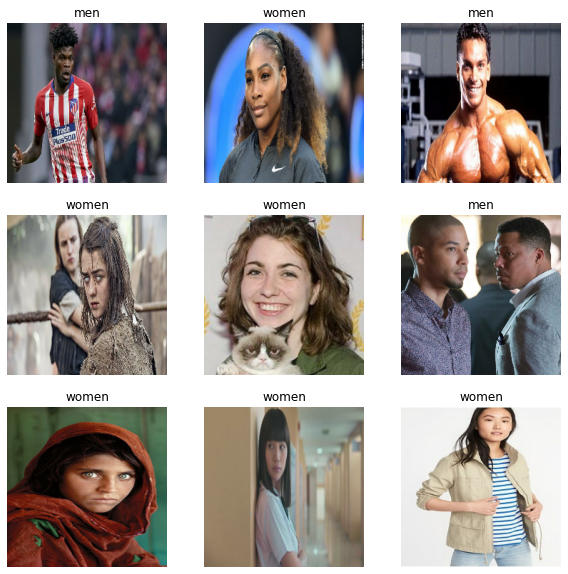

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
tf.keras.backend.clear_session()

base_model = ResNet50(weights="imagenet", input_shape=TARGET_SHAPE, include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT_RATE)(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(DROPOUT_RATE)(x)
x = BatchNormalization()(x)

output = Dense(1, activation="sigmoid")(x)

gender_classifier = Model(base_model.input, output, name="Gender_Classifier")
gender_classifier.compile(optimizer=optimizers.Adam(LEARNING_RATE), loss=losses.BinaryCrossentropy(), metrics=["accuracy"])
gender_classifier.summary()

Model: "Gender_Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________

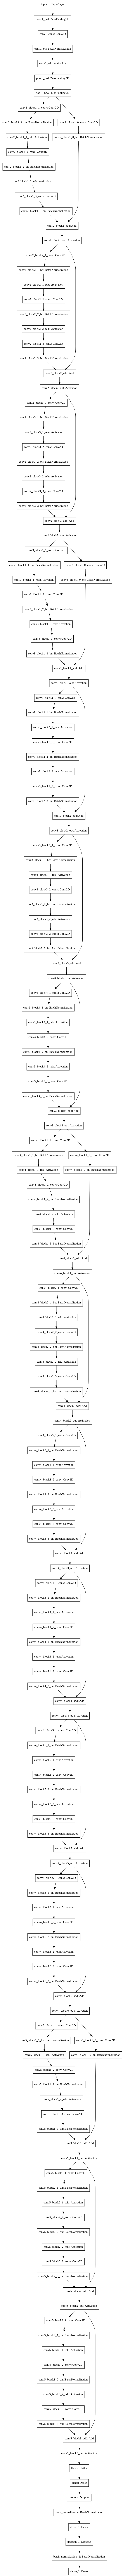

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(gender_classifier)

In [9]:
model_checkpoint = callbacks.ModelCheckpoint("gender_classification_model.h5", monitor="val_accuracy", mode="max", save_best_only=True)
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=10)

gender_classifier.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[model_checkpoint, earlystopping])

Epoch 1/100
167/167 [==============================] - 100s 207ms/step - loss: 0.4066 - accuracy: 0.8158 - val_loss: 0.1537 - val_accuracy: 0.9444
Epoch 2/100
167/167 [==============================] - 22s 134ms/step - loss: 0.0902 - accuracy: 0.9675 - val_loss: 0.0887 - val_accuracy: 0.9647
Epoch 3/100
167/167 [==============================] - 22s 131ms/step - loss: 0.0314 - accuracy: 0.9928 - val_loss: 0.0863 - val_accuracy: 0.9685
Epoch 4/100
167/167 [==============================] - 22s 131ms/step - loss: 0.0121 - accuracy: 0.9992 - val_loss: 0.0972 - val_accuracy: 0.9662
Epoch 5/100
167/167 [==============================] - 22s 132ms/step - loss: 0.0108 - accuracy: 0.9977 - val_loss: 0.0953 - val_accuracy: 0.9730
Epoch 6/100
167/167 [==============================] - 22s 132ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0818 - val_accuracy: 0.9760
Epoch 7/100
167/167 [==============================] - 22s 131ms/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.1067 

In [12]:
!cp gender_classification_model.h5 /content/drive/MyDrive/Myntra